<a href="https://colab.research.google.com/github/alexiej/laboratory/blob/master/DW_Poznan_DataWorkshop_7_ALL_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import  string 
import re

import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

!nvidia-smi

TensorFlow 2.x selected.
Tensorflow version:  2.1.0
Mon Mar  9 12:03:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                        

# 0. Pobieranie Danych

Wymagania co do projektu KERAS, które odbędzie się za dwa tygodnie.
KERAS - klasyfikacja tweetów. Dataset z którego będziemy korzystać to: https://www.kaggle.com/kazanova/sentiment140/kernels, jest to prosta binarna klasyfikacja tekstu

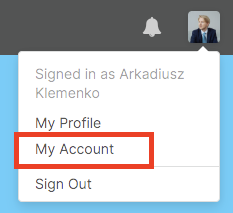

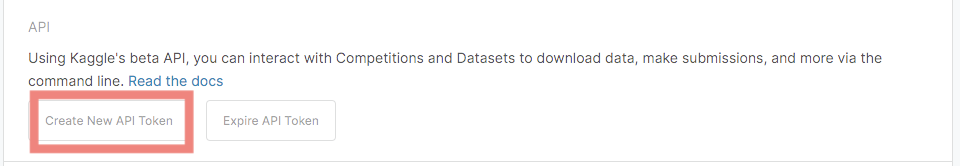

In [0]:
from google.colab import files
print("Please upload kaggle.json file.. \n")

uploaded = files.upload()

Please upload kaggle.json file.. 



Saving kaggle.json to kaggle.json


In [0]:
!pip install -U -q kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kazanova/sentiment140
!unzip -o sentiment140.zip
!ls


DATASET_FILE = 'training.1600000.processed.noemoticon.csv'
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset = pd.read_csv(DATASET_FILE,encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

dataset.head()

     |████████████████████████████████| 122kB 3.5MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.11.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
 98% 79.0M/80.9M [00:00<00:00, 76.6MB/s]
100% 80.9M/80.9M [00:00<00:00, 92.7MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  
kaggle.json  sentiment140.zip
sample_data  training.1600000.processed.noemoticon.csv


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# 1. Preprocessing NLP

* Usuwanie tagów HTML, i quotes.

In [0]:
def clean_review(text):
    #Remove URL
    text = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', text, flags=re.MULTILINE)

    # Strip HTML tags
    text = re.sub('<[^<]+?>', ' ', text)
 
    # Strip escaped quotes
    text = text.replace('\\"', '')
 
    # Strip quotes
    text = text.replace('"', '')
 
    return text

dataset['text_nourl'] = dataset['text'].apply(clean_review)
dataset.head()

,target,ids,date,flag,user,text,text_nourl
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."



*    Usuwanie nicków z tekstu



In [0]:
def remove_nickname(text):
    text_nonick=re.sub(r"^@[a-zA-Z0-9]*", "", text) 
    return text_nonick

dataset['text_nonick'] = dataset['text_nourl'].apply(lambda x: remove_nickname(x))

In [0]:
dataset.head()

,target,ids,date,flag,user,text,text_nourl,text_nonick
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho...","- Awww, that's a bummer. You shoulda got Da..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."


* Usuwanie znaków interpunkcyjnych

In [0]:
def remove_punctuation(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

dataset['text_punct'] = dataset['text_nonick'].apply(lambda x: remove_punctuation(x))

In [0]:
dataset.head()

,target,ids,date,flag,user,text,text_nourl,text_nonick,text_punct
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho...","- Awww, that's a bummer. You shoulda got Da...",Awww thats a bummer You shoulda got David ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...,I dived many times for the ball Managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",no its not behaving at all im mad why am i he...


* Tokenizacja

In [0]:
 def tokenize(text):
        tokens = re.split('\W+', text) 
        return tokens

In [0]:
dataset['tokens'] = dataset['text_punct'].apply(lambda x: tokenize(x))

In [0]:
dataset.head()

,target,ids,date,flag,user,text,text_nourl,text_nonick,text_punct,tokens
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho...","- Awww, that's a bummer. You shoulda got Da...",Awww thats a bummer You shoulda got David ...,"[, Awww, thats, a, bummer, You, shoulda, got, ..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,"[is, upset, that, he, cant, update, his, Faceb..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...,I dived many times for the ball Managed to sa...,"[, I, dived, many, times, for, the, ball, Mana..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",no its not behaving at all im mad why am i he...,"[, no, its, not, behaving, at, all, im, mad, w..."




*  Usuwanie stopwords



In [0]:
nltk.download('stopwords')

def remove_stopwords(tokenized_list):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in tokenized_list if word not in stopword]
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
dataset['stop_words']=dataset['tokens'].apply(lambda x:remove_stopwords(x))

In [0]:
dataset.head()

,target,ids,date,flag,user,text,text_nourl,text_nonick,text_punct,tokens,stop_words
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho...","- Awww, that's a bummer. You shoulda got Da...",Awww thats a bummer You shoulda got David ...,"[, Awww, thats, a, bummer, You, shoulda, got, ...","[, Awww, thats, bummer, You, shoulda, got, Dav..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,"[is, upset, that, he, cant, update, his, Faceb...","[upset, cant, update, Facebook, texting, might..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...,I dived many times for the ball Managed to sa...,"[, I, dived, many, times, for, the, ball, Mana...","[, I, dived, many, times, ball, Managed, save,..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire, ]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",no its not behaving at all im mad why am i he...,"[, no, its, not, behaving, at, all, im, mad, w...","[, behaving, im, mad, I, cant, see, ]"


* Lematyzacja

In [0]:
def lemmatizing(tokenized_text):
        wn = nltk.WordNetLemmatizer()
        text = [wn.lemmatize(word) for word in tokenized_text]
        return text

In [0]:
nltk.download('wordnet')
dataset['lemmas'] = dataset['stop_words'].apply(lambda x: lemmatizing(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
dataset.head()

,target,ids,date,flag,user,text,text_nourl,text_nonick,text_punct,tokens,stop_words,lemmas
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho...","- Awww, that's a bummer. You shoulda got Da...",Awww thats a bummer You shoulda got David ...,"[, Awww, thats, a, bummer, You, shoulda, got, ...","[, Awww, thats, bummer, You, shoulda, got, Dav...","[, Awww, thats, bummer, You, shoulda, got, Dav..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,"[is, upset, that, he, cant, update, his, Faceb...","[upset, cant, update, Facebook, texting, might...","[upset, cant, update, Facebook, texting, might..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...,I dived many times for the ball Managed to sa...,"[, I, dived, many, times, for, the, ball, Mana...","[, I, dived, many, times, ball, Managed, save,...","[, I, dived, many, time, ball, Managed, save, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire, ]","[whole, body, feel, itchy, like, fire, ]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",no its not behaving at all im mad why am i he...,"[, no, its, not, behaving, at, all, im, mad, w...","[, behaving, im, mad, I, cant, see, ]","[, behaving, im, mad, I, cant, see, ]"


Standaryzacja do małych liter

In [0]:
def to_lowercase(tokenized_text):
        text = [word.lower() for word in tokenized_text]
        return text

dataset['std_lemmas'] = dataset['lemmas'].apply(lambda x: to_lowercase(x))

In [0]:
dataset.head()

,target,ids,date,flag,user,text,text_nourl,text_nonick,text_punct,tokens,stop_words,lemmas,std_lemmas
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho...","- Awww, that's a bummer. You shoulda got Da...",Awww thats a bummer You shoulda got David ...,"[, Awww, thats, a, bummer, You, shoulda, got, ...","[, Awww, thats, bummer, You, shoulda, got, Dav...","[, Awww, thats, bummer, You, shoulda, got, Dav...","[, awww, thats, bummer, you, shoulda, got, dav..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,"[is, upset, that, he, cant, update, his, Faceb...","[upset, cant, update, Facebook, texting, might...","[upset, cant, update, Facebook, texting, might...","[upset, cant, update, facebook, texting, might..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...,I dived many times for the ball Managed to sa...,"[, I, dived, many, times, for, the, ball, Mana...","[, I, dived, many, times, ball, Managed, save,...","[, I, dived, many, time, ball, Managed, save, ...","[, i, dived, many, time, ball, managed, save, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire, ]","[whole, body, feel, itchy, like, fire, ]","[whole, body, feel, itchy, like, fire, ]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",no its not behaving at all im mad why am i he...,"[, no, its, not, behaving, at, all, im, mad, w...","[, behaving, im, mad, I, cant, see, ]","[, behaving, im, mad, I, cant, see, ]","[, behaving, im, mad, i, cant, see, ]"


In [0]:
dataset.to_csv('preprocessed_file.csv', index=False)



```
# This is formatted as code
```

* Usuwanie zbędnych kolumn

In [0]:
drop_columns = ['text_nourl','text_nonick','tokens','stop_words','text_punct','text','lemmas'] 
dataset.drop(drop_columns, axis=1, inplace=True)

In [0]:
dataset.head()

,target,ids,date,flag,user,std_lemmas
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[, awww, thats, bummer, you, shoulda, got, dav..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, cant, update, facebook, texting, might..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[, i, dived, many, time, ball, managed, save, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire, ]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[, behaving, im, mad, i, cant, see, ]"


# 2. Podstawy KERAS

In [0]:
from tensorflow import keras

Pobieranie i kilka statystyk odnośnie danych

In [0]:
mnist_test = pd.read_csv('./sample_data/mnist_test.csv', header=None)
mnist_train = pd.read_csv('./sample_data/mnist_train_small.csv',header=None)

In [0]:
print(f'Rozmiar zbioru testowego: {mnist_test.shape}' )
print(f'Rozmiar zbioru treningowego:{mnist_train.shape}')
print(f'Przyładowe 5 pierwszych wierszy:\n{mnist_train.head(5)}')

Rozmiar zbioru testowego: (10000, 785)
Rozmiar zbioru treningowego:(20000, 785)
Przyładowe 5 pierwszych wierszy:
   0    1    2    3    4    5    6    ...  778  779  780  781  782  783  784
0    6    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
1    5    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
2    7    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
3    9    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
4    5    0    0    0    0    0    0  ...    0    0    0    0    0    0    0

[5 rows x 785 columns]


Przygotywanie danych na dwa podzbiory: labels and set

In [0]:
def get_features(df):
    features = df.values[:,1:]/255
    labels=df[0].values
    return features, labels

In [0]:
train_set, train_labels = get_features(mnist_train)
test_set, test_labels = get_features(mnist_test)

In [0]:
example_index=221
print(mnist_train.iloc[example_index,0])

9


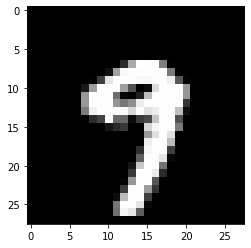

In [0]:


plt.figure()
_=plt.imshow(np.reshape(train_set[example_index,:],(28,28)),'gray')

![Neuron](https://scx1.b-cdn.net/csz/news/800/2018/2-whyareneuron.jpg)

![Jak to działa](https://www.mathworks.com/discovery/deep-learning/_jcr_content/mainParsys/band_2123350969_copy_1983242569/mainParsys/columns_1635259577/1/image_2128876021_cop_1731669336.adapt.full.high.svg/1576732338948.svg)

Mały słowniczek pojęć:

Dense : Gęsto połączona warstwa NN(sieci neuronowej).

Conv1D : Warstwa, która bazuje na jednym wymiarze np. teks, liczby

Conv2D: Warstwa do przetwarzania większej liczby wymiarów np. obrazów (pixel, głębia koloru)

Dropout - Zapobiega przeuczeniu. Losowo gubi sygnały wejścia.

{Type}PoolXD - np. MaxPool2D. Służy do zmniejszenia liczby parametrów w naszym modelu poprzez przesuwanie filtra zbiorczego.

Optimizer - optymalizacja naszej sieci. Coś w stylu gradientu w funkcjach

Loss - Funkcja sprawdza jak model pasuje do naszej sieci. Coś w stylu R2 w modelach liniowych

Zamieniamy nasze kategorie na macierze, ponieważ keras tak samo jak tensorflow przetwarza macierze. Po kategoryzacji otrzymujemy zbiór binarnych macierzy.



In [0]:
print(f'Rozmiar macierzy przed zamianą {train_labels.shape}')
train_labels = keras.utils.to_categorical(train_labels)
print(f'Rozmiary macierzy po zamianie: {train_labels.shape}')
test_labels = keras.utils.to_categorical(test_labels)


Rozmiar macierzy przed zamianą (20000,)
Rozmiary macierzy po zamianie: (20000, 10)


In [0]:
print(f'Rozmiar macierzy przed zamianą {test_labels.shape}')
test_labels1 = keras.utils.to_categorical(test_labels)
print(f'Rozmiary macierzy po zamianie: {test_labels1.shape}')


Rozmiar macierzy przed zamianą (10000, 10)
Rozmiary macierzy po zamianie: (10000, 10, 2)


Po zamianie dochodzi nowy wymiar macierzy.
Wiersze zgadzają się tym przed zmianą. Jeżeli cyfrą było 6 to na pozycji 6 będzie wartość 1.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D

# optimizer, data generator and learning rate reductor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [0]:


dim = 28
nclasses = train_labels.shape[1]
print(f"Liczba klas: {nclasses}")
print(f"Rozmiar zbioru traningowego {train_set.shape}")
model = Sequential()



model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30, activation=tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(20, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))


model.summary()

Liczba klas: 10
Rozmiar zbioru traningowego (20000, 784)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
EPOCHS=6
BATCH_SIZE=128

In [0]:
history =model.fit(train_set,train_labels,epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.25)

Train on 15000 samples, validate on 5000 samples
Epoch 1/6
15000/15000 [==============================] - 3s 183us/sample - loss: 1.1205 - accuracy: 0.6897 - val_loss: 0.4857 - val_accuracy: 0.8648
Epoch 2/6
15000/15000 [==============================] - 1s 39us/sample - loss: 0.3920 - accuracy: 0.8903 - val_loss: 0.3326 - val_accuracy: 0.9084
Epoch 3/6
15000/15000 [==============================] - 1s 41us/sample - loss: 0.3022 - accuracy: 0.9119 - val_loss: 0.2870 - val_accuracy: 0.9182
Epoch 4/6
15000/15000 [==============================] - 1s 40us/sample - loss: 0.2602 - accuracy: 0.9240 - val_loss: 0.2598 - val_accuracy: 0.9248
Epoch 5/6
15000/15000 [==============================] - 1s 41us/sample - loss: 0.2328 - accuracy: 0.9339 - val_loss: 0.2482 - val_accuracy: 0.9294
Epoch 6/6
15000/15000 [==============================] - 1s 41us/sample - loss: 0.2117 - accuracy: 0.9385 - val_loss: 0.2401 - val_accuracy: 0.9310


Sprawdźmy jak uczył się nasz model

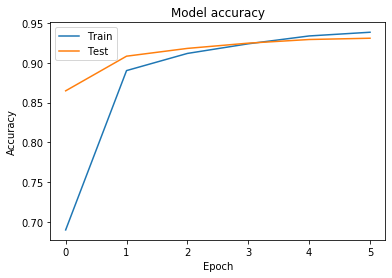

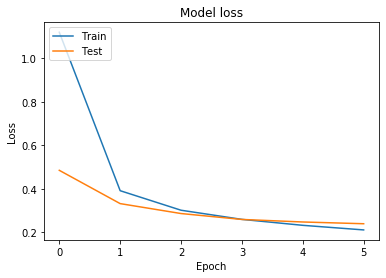

In [0]:


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Tokenizacja

Tokenizacja pozwoli nam na zmianę wartości tekstowych na wektor liczb który dalej posłuży nam do uczenia sieci. 

**Sentyment** na wartość binarną:

In [0]:
# Wybieramy że naszym inputem jest 'std_lemmas'

dataset['input'] = dataset['std_lemmas']
dataset['target'] = dataset['target'].replace(4,1)

print(dataset['target'].unique())

[0 1]


Dzielimy nasz tekst na część do testowania i trenowania, tak że 20% tekstu znajdzie się w części testowej zbioru danych,

In [0]:
from sklearn.model_selection import train_test_split

data_limited = dataset#.iloc[:300000]
X_train_text, X_test_text, y_train, y_test = train_test_split(data_limited['input'], data_limited['target'], test_size=0.2)

print(X_train_text.shape)
print(X_test_text.shape)
print(y_train.shape)
print(y_test.shape)

(1280000,)
(320000,)
(1280000,)
(320000,)


Trenujemy na naszym zbiorze traningowym tekst, **Dlaczego tylko zbiór treningowy?**: Nasz sieć uczy się na liczbach (input), które wchodzą do sieci. Jeśli zbiór treningowy nie zawiera jakieś klasy (liczby odpowiadającej za dane słowo), to sieć na tej klasie nic się nie nauczy. Dlatego wszystkie słowa które nie wpadły do zbioru treningowego powinny być traktowane jako **OTHERS** i nie powinny brać udziału w uczeniu.

In [0]:
%%time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)

CPU times: user 12.2 s, sys: 145 ms, total: 12.4 s
Wall time: 12.4 s


In [0]:
vocab_size = N_FEATURES =  len(tokenizer.word_index) + 1
print("Nasz słownik zawiera ", vocab_size , " słów")

Nasz słownik zawiera  435039  słów


Teraz przyszła pora na zmianę naszego zbioru na odpowiadające im liczby. **pad_sequences** zawiera kilka interesujących parametrów:

* `maxlen` - Maksymalna długość tekstu, Powoduje że jeżeli tekst źródłowy jest krotszy to nastąpi jego skrócenie i ucięcie tekstu. Jest to wymagane gdyż `input` do sieci musi mieć stałą długość.
* `padding` - Tak jak wyżej, jeżeli tekst jest za krótki to jest wypełniany zerami. `pre` - powoduje że tekst na początku jest wypełniany zeramy. W przypadku `post` - To po zakończeniu tekstu dodawane są zera
* `truncating` - Tak jak w przypadku `padding` tym razem `pre` oznacza że początek tekstu jest skracany, natomiast `post` koniec tekstu jest ucinany. 

In [0]:
%%time
SEQUENCE_LENGTH = 300

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=SEQUENCE_LENGTH,padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=SEQUENCE_LENGTH,padding='post', truncating='post')

CPU times: user 18.4 s, sys: 561 ms, total: 18.9 s
Wall time: 18.9 s


In [0]:
for i in range(10):
  print(i,") ",len(X_train_text.iloc[i]), " -> " , len(X_train[i]) ,":",", ".join(X_train_text.iloc[i]), " -> ", ", ".join(X_train[i].astype(str)))

0 )  9  ->  300 : cant, wait, get, hell, nc, in2, heaven, wv,   ->  16, 78, 6, 349, 3412, 7137, 1938, 13905, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
1 )  5  ->  300 

In [0]:
print(X_train.shape)
print(X_test.shape)

(1280000, 300)
(320000, 300)


# 3. Podstawowa Sieć

Do budowy sieci użyty zostanie wstępnie oczyszczony tekst, by prześledzić proces krok po kroku:

Budowa modelu:

In [0]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
 
model = Sequential()
 
model.add(Dense(units=1000, activation='relu', input_dim=SEQUENCE_LENGTH))
model.add(Dense(units=1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              301000    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1001      
Total params: 302,001
Trainable params: 302,001
Non-trainable params: 0
_________________________________________________________________


Trenowanie modelu:

In [0]:
history = model.fit(X_train[:-100], y_train[:-100], 
          epochs=20, batch_size=64, verbose=1, 
          validation_data=(X_train[-100:], y_train[-100:]))

Train on 1279900 samples, validate on 100 samples
Epoch 1/20
1279900/1279900 [==============================] - 72s 56us/sample - loss: 35.7003 - accuracy: 0.5020 - val_loss: 11.5838 - val_accuracy: 0.4400
Epoch 2/20
1279900/1279900 [==============================] - 71s 56us/sample - loss: 1.4437 - accuracy: 0.4999 - val_loss: 16.4521 - val_accuracy: 0.4500
Epoch 3/20
1279900/1279900 [==============================] - 71s 56us/sample - loss: 1.0568 - accuracy: 0.5005 - val_loss: 0.6847 - val_accuracy: 0.5600
Epoch 4/20
1279900/1279900 [==============================] - 71s 55us/sample - loss: 0.9508 - accuracy: 0.5008 - val_loss: 33.8718 - val_accuracy: 0.5500
Epoch 5/20
1279900/1279900 [==============================] - 71s 55us/sample - loss: 0.8768 - accuracy: 0.5019 - val_loss: 4.5297 - val_accuracy: 0.5500
Epoch 6/20
1279900/1279900 [==============================] - 72s 56us/sample - loss: 0.8014 - accuracy: 0.5020 - val_loss: 0.6937 - val_accuracy: 0.4500
Epoch 7/20
1279900/127

Ewaluacja modelu - zwracany jest loss (błąd?) oraz accuracy (dokładność predykcji w przedziale <0; 1>)

In [0]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print("Training Accuracy: {:.4f}, Loss: {:.4f}".format(accuracy, loss))

320000/320000 [==============================] - 20s 64us/sample - loss: 0.7247 - accuracy: 0.4990
Training Accuracy: 0.4990, Loss: 0.7247


Do wizualizacji procesu uczenia wykres przebiegu loss i accuracy wobec liczby epok:

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

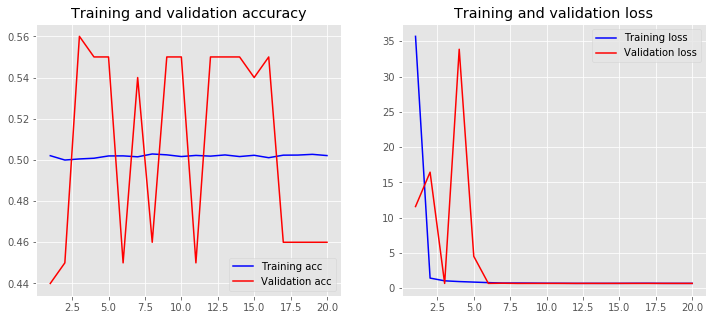

In [0]:
plot_history(history)



 - czyli sieci konwolucyjne które mogą poprawić sieć: https://nlpforhackers.io/keras-intro/ -> @Pieczarka 

![Jak działa konwulsja](https://ikhlestov.github.io/images/ML_notes/convolutions/01_simple_convolution.jpg)

![Warstwa konwulsyjna](https://i.imgur.com/5UQz1zI.jpg)

Tworzenie modelu

In [0]:
from tensorflow.python.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding
from tensorflow.python.keras import Sequential
 
EMBEDDING_SIZE = 64

model_conv = Sequential()

model_conv.add(Embedding(N_FEATURES + 1, EMBEDDING_SIZE, input_length=SEQUENCE_LENGTH))
model_conv.add(Conv1D(64, 5, activation='relu'))
  
model_conv.add(MaxPooling1D(5))
model_conv.add(Flatten())

model_conv.add(Dense(units=64, activation='relu'))
model_conv.add(Dense(units=1, activation='sigmoid'))
 
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 64)           27842560  
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3776)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                241728    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 28,104,897
Trainable params: 28,104,897
Non-trainable params: 0
__________________________________________

Embeding
"słownik mapujący indeksy słów na zmiennoprzecinkowe gęste wektory"

![alt text](https://i.postimg.cc/Vs3p5KDM/embedding.png)

*   To my określamy liczbę wymiarów (a nie jak w one-hot jest to liczba unikalnych elementów)
*   warstwa potfafi znaleźć wewnętrzne podobieństwa między elementami, a nawet grupować je w podobne kategorie
*   efektywniejsze obliczenia





Funkcje aktywacji 

*   to funkcje używane do obliczania wartości wyjścia neuronów
*   więcej pod linkiem : [Funkcje aktywacji](https://mlfromscratch.com/content/images/size/w2000/2019/12/activation-functions.gif)



![alt text](https://alexiej.github.io/assets/img/1_p_hyqAtyI8pbt2kEl6siOQ.614e078a.png)

Max pooling


*   służy do redukcji wymiarowości
*   w tym przypadku wartości max z pewnych rozłącznych obszarów
*   są też inne podejścia np averagePooling (średnia)



![Max pooling](https://i.postimg.cc/Jh1QGkfj/maxpoling.png)

Keras API - tworzenie modelu


*   To ten sam model co poprzednio
*   Umożliwia tworzenie bardziej skomplikowanych połączeń (rozgałęzień, dodatkowych wejść lub wyjść)



In [0]:
from tensorflow.python.keras.models import Model, Input

model_input = Input(shape=X_train.shape[1:],  name='inputs')

m = Embedding(N_FEATURES + 1, EMBEDDING_SIZE, input_length=SEQUENCE_LENGTH, name='embedding_layer')(model_input)
m = Conv1D(64, 5, activation='relu')(m)
m = MaxPooling1D(5)(m)
m = Flatten()(m)
m = Dense(64, activation='relu')(m)
model_output = Dense(1, activation='sigmoid')(m)


model = Model(inputs=model_input, outputs=model_output)
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 64)           27842560  
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3776)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                241728    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 28,104,897
Trainable params: 28,104,897
Non-trainable params: 0
__________________________________________

Trenowanie modelu


In [0]:
history_conv = model_conv.fit(X_train[:-100], y_train[:-100], 
          epochs=5, batch_size=8192, verbose=1,
          validation_data=(X_train[-100:], y_train[-100:]))


Train on 1279900 samples, validate on 100 samples
Epoch 1/5
1279900/1279900 [==============================] - 121s 94us/sample - loss: 0.5139 - accuracy: 0.7384 - val_loss: 0.4480 - val_accuracy: 0.7800
Epoch 2/5
1279900/1279900 [==============================] - 114s 89us/sample - loss: 0.4046 - accuracy: 0.8175 - val_loss: 0.4273 - val_accuracy: 0.8000
Epoch 3/5
1279900/1279900 [==============================] - 114s 89us/sample - loss: 0.3491 - accuracy: 0.8485 - val_loss: 0.4051 - val_accuracy: 0.8100
Epoch 4/5
1279900/1279900 [==============================] - 114s 89us/sample - loss: 0.2957 - accuracy: 0.8755 - val_loss: 0.4397 - val_accuracy: 0.8200
Epoch 5/5
1279900/1279900 [==============================] - 114s 89us/sample - loss: 0.2537 - accuracy: 0.8949 - val_loss: 0.4059 - val_accuracy: 0.8200


Ewaluacja




In [0]:
loss, accuracy = model_conv.evaluate(X_test, y_test, verbose=True)
print("Training Accuracy: {:.4f}, Loss: {:.4f}".format(accuracy, loss))

320000/320000 [==============================] - 38s 119us/sample - loss: 0.5053 - accuracy: 0.7852
Training Accuracy: 0.7852, Loss: 0.5053


Ładne wykresy :P

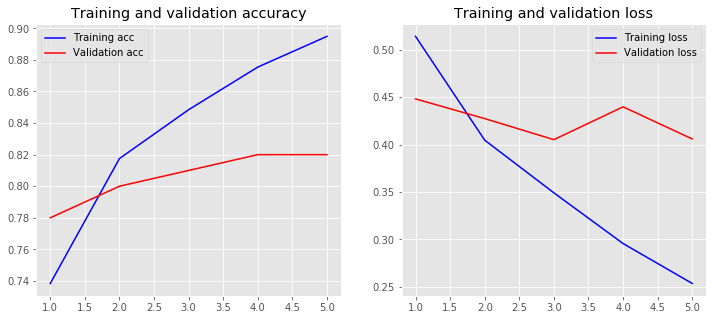

In [0]:
plot_history(history_conv)

# 5. LSTM Network (long short term memory)


https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714

* Pozwala traktować jako sekwencje zamiast jako całość. 
* Wejście musi zawierać 3 wymiary:  samples, time steps, and features

Więcej modeli może być znalezionych na:

https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-lstm


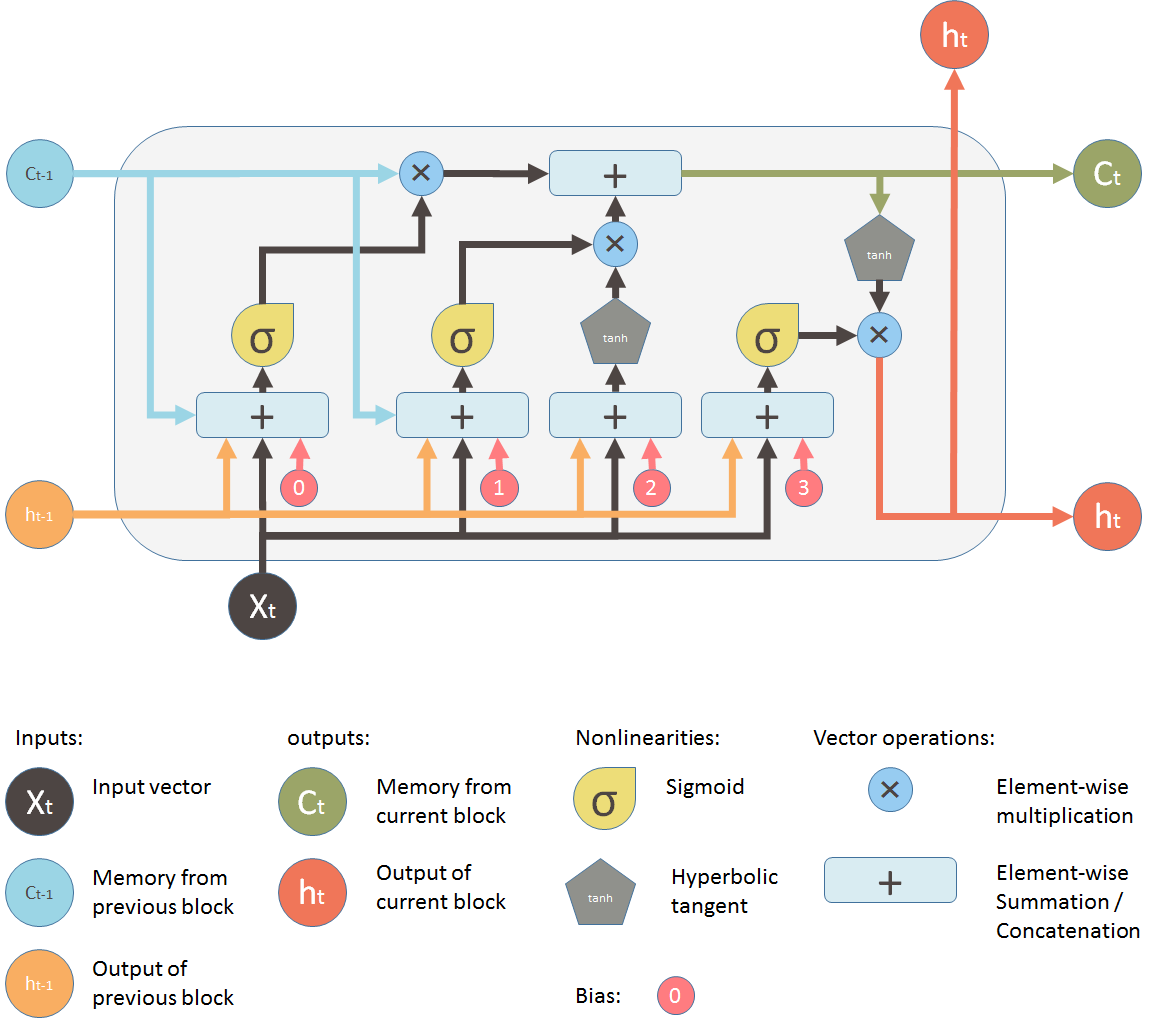

W poniższej sieci. Mamy sieć która ma None to nasz batch_size, 300 słów będących po sobie po kolei (to jest drugi wymiar - time_series), i wielkość parametrów do naszego wymiaru - 64 features.

In [0]:
from tensorflow.python.keras.layers import LSTM


EMBEDDING_SIZE = 64

model_lstm = Sequential()
model_lstm.add(Embedding(N_FEATURES + 1,  output_dim=EMBEDDING_SIZE, input_length=SEQUENCE_LENGTH))
# Add a 32 unit LSTM layer
model_lstm.add(LSTM(units=32))

model_lstm.add(Dense(units=64, activation='relu'))
model_lstm.add(Dense(units=1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 64)           27842560  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 27,857,153
Trainable params: 27,857,153
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_lstm = model_lstm.fit(X_train, y_train, 
          epochs=5, batch_size=8192, verbose=1,
          validation_split=0.2)

Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
1024000/1024000 [==============================] - 215s 210us/sample - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 2/5
1024000/1024000 [==============================] - 213s 208us/sample - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 3/5
1024000/1024000 [==============================] - 213s 208us/sample - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 4/5
1024000/1024000 [==============================] - 213s 208us/sample - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 5/5
1024000/1024000 [==============================] - 213s 208us/sample - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5002


In [0]:
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=True)
print("Training Accuracy: {:.4f}, Loss: {:.4f}".format(accuracy, loss))

320000/320000 [==============================] - 1217s 4ms/sample - loss: 0.6931 - accuracy: 0.5016
Training Accuracy: 0.5016, Loss: 0.6931


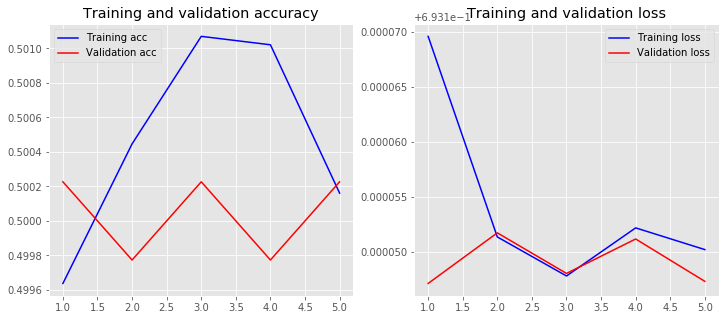

In [0]:
plot_history(history_lstm)

## LSTM + CONV1D

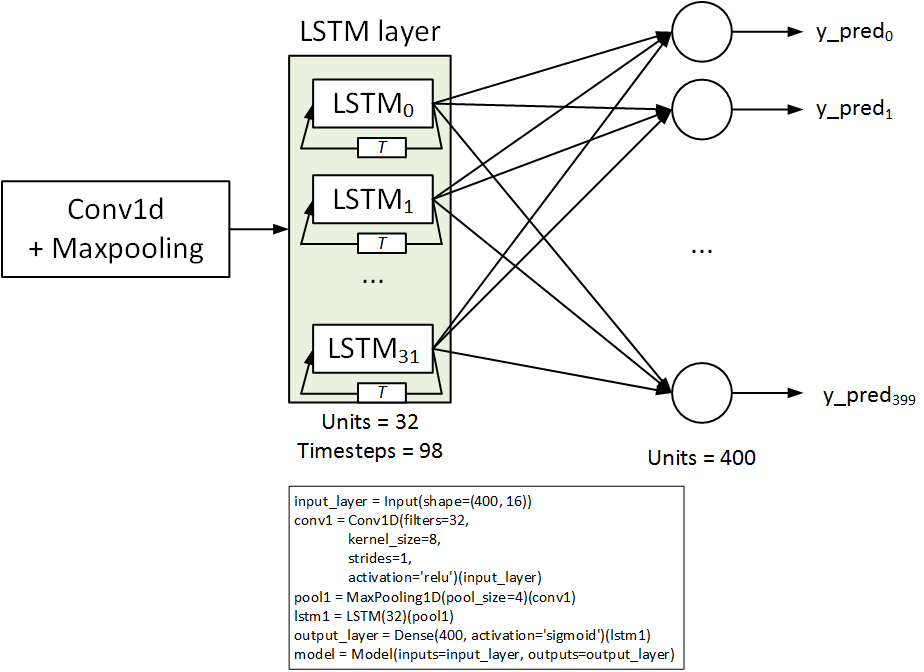

In [0]:
EMBEDDING_SIZE = 64

model_lstm_cnv = Sequential()
model_lstm_cnv.add(Embedding(N_FEATURES + 1,  output_dim=EMBEDDING_SIZE, input_length=SEQUENCE_LENGTH))


model_lstm_cnv.add(Conv1D(64, 5, activation='relu'))
model_lstm_cnv.add(MaxPooling1D(32))
model_lstm_cnv.add(LSTM(units=32))

model_lstm_cnv.add(Dense(units=64, activation='relu'))
model_lstm_cnv.add(Dense(units=1, activation='sigmoid'))

model_lstm_cnv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_cnv.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 64)           27842560  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 296, 64)           20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 27,877,697
Trainable params: 27,877,697
Non-trainable params: 0
__________________________________________

In [0]:
%%time
history_lstm_cnv = model_lstm_cnv.fit(X_train, y_train, 
          epochs=5, batch_size=8192, verbose=1,
          validation_split=0.2)

Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
1024000/1024000 [==============================] - 123s 120us/sample - loss: 0.5598 - accuracy: 0.6905 - val_loss: 0.4458 - val_accuracy: 0.7937
Epoch 2/5
1024000/1024000 [==============================] - 120s 118us/sample - loss: 0.4103 - accuracy: 0.8153 - val_loss: 0.4326 - val_accuracy: 0.8009
Epoch 3/5
1024000/1024000 [==============================] - 120s 117us/sample - loss: 0.3397 - accuracy: 0.8546 - val_loss: 0.4507 - val_accuracy: 0.7956
Epoch 4/5
1024000/1024000 [==============================] - 120s 118us/sample - loss: 0.2655 - accuracy: 0.8920 - val_loss: 0.4907 - val_accuracy: 0.7889
Epoch 5/5
1024000/1024000 [==============================] - 121s 118us/sample - loss: 0.2104 - accuracy: 0.9177 - val_loss: 0.5350 - val_accuracy: 0.7795
CPU times: user 10min 31s, sys: 1min 16s, total: 11min 47s
Wall time: 10min 4s


In [0]:
loss, accuracy = model_lstm_cnv.evaluate(X_test, y_test, verbose=True)
print("Training Accuracy: {:.4f}, Loss: {:.4f}".format(accuracy, loss))

320000/320000 [==============================] - 80s 249us/sample - loss: 0.5391 - accuracy: 0.7783
Training Accuracy: 0.7783, Loss: 0.5391


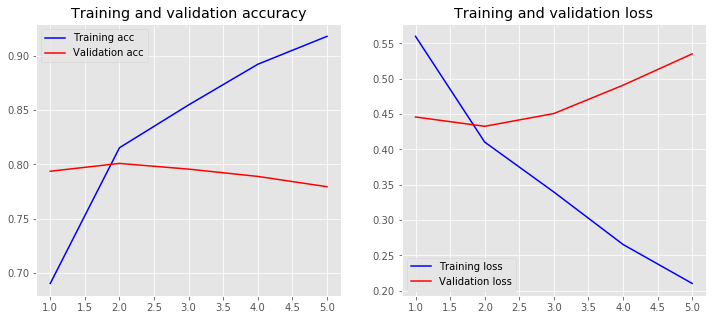

In [0]:
plot_history(history_lstm_cnv)

# 6. Dropout

In [0]:
from tensorflow.python.keras.layers import Dropout

In [0]:
model_dropout = Sequential()
model_dropout.add(Embedding(N_FEATURES + 1,  output_dim=EMBEDDING_SIZE, input_length=SEQUENCE_LENGTH))


model_dropout.add(Conv1D(64, 5, activation='relu'))
model_dropout.add(MaxPooling1D(32))
model_dropout.add(Dropout(0.5))
model_dropout.add(LSTM(units=32))

model_dropout.add(Dense(units=64, activation='relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(units=1, activation='sigmoid'))

model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dropout.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 64)           27842560  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 64)           20544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [0]:
%%time
history_dropout = model_dropout.fit(X_train, y_train, 
          epochs=5, batch_size=8192, verbose=1,
          validation_split=0.2)

Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
1024000/1024000 [==============================] - 124s 121us/sample - loss: 0.5859 - accuracy: 0.6709 - val_loss: 0.4561 - val_accuracy: 0.7892
Epoch 2/5
1024000/1024000 [==============================] - 120s 117us/sample - loss: 0.4424 - accuracy: 0.8019 - val_loss: 0.4408 - val_accuracy: 0.7958
Epoch 3/5
1024000/1024000 [==============================] - 120s 117us/sample - loss: 0.3890 - accuracy: 0.8321 - val_loss: 0.4469 - val_accuracy: 0.7943
Epoch 4/5
1024000/1024000 [==============================] - 121s 118us/sample - loss: 0.3404 - accuracy: 0.8577 - val_loss: 0.4650 - val_accuracy: 0.7906
Epoch 5/5
1024000/1024000 [==============================] - 120s 117us/sample - loss: 0.3017 - accuracy: 0.8759 - val_loss: 0.4869 - val_accuracy: 0.7871
CPU times: user 10min 28s, sys: 1min 16s, total: 11min 45s
Wall time: 10min 4s


In [0]:
loss, accuracy = model_dropout.evaluate(X_test, y_test, verbose=True)
print("Training Accuracy: {:.4f}, Loss: {:.4f}".format(accuracy, loss))

320000/320000 [==============================] - 84s 261us/sample - loss: 0.4876 - accuracy: 0.7883
Training Accuracy: 0.7883, Loss: 0.4876


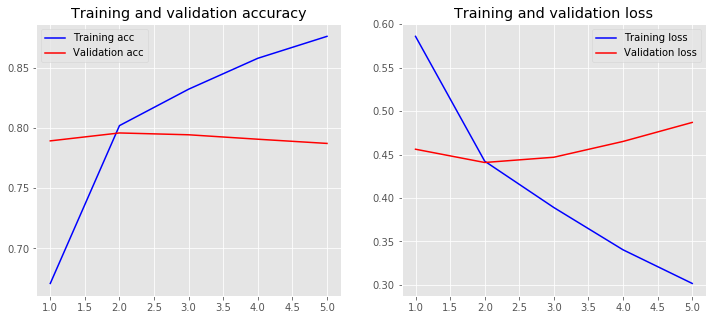

In [0]:
plot_history(history_dropout)

# 7. BatchNormalization

In [0]:
from tensorflow.python.keras.layers import BatchNormalization

In [0]:
model_dropout_batchnorm = Sequential()
model_dropout_batchnorm.add(Embedding(N_FEATURES + 1,  output_dim=EMBEDDING_SIZE, input_length=SEQUENCE_LENGTH))


model_dropout_batchnorm.add(Conv1D(64, 5, activation='relu', use_bias=False))
model_dropout_batchnorm.add(MaxPooling1D(32))
model_dropout_batchnorm.add(Dropout(0.5))

model_dropout_batchnorm.add(BatchNormalization())
model_dropout_batchnorm.add(Dropout(0.5))
model_dropout_batchnorm.add(LSTM(units=32))

model_dropout_batchnorm.add(Dense(units=64, activation='relu'))

model_dropout_batchnorm.add(BatchNormalization())
model_dropout_batchnorm.add(Dropout(0.5))
model_dropout_batchnorm.add(Dense(units=1, activation='sigmoid'))

model_dropout_batchnorm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dropout_batchnorm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 64)           27842560  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 296, 64)           20480     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 64)             256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)               

In [0]:
%%time
history_dropout_batchnorm = model_dropout_batchnorm.fit(X_train, y_train, 
          epochs=5, batch_size=8192, verbose=1,
          validation_split=0.2)

Train on 1024000 samples, validate on 256000 samples
Epoch 1/5
1024000/1024000 [==============================] - 123s 120us/sample - loss: 0.6413 - accuracy: 0.6340 - val_loss: 0.6856 - val_accuracy: 0.6645
Epoch 2/5
1024000/1024000 [==============================] - 119s 116us/sample - loss: 0.4717 - accuracy: 0.7865 - val_loss: 0.6862 - val_accuracy: 0.5002
Epoch 3/5
1024000/1024000 [==============================] - 119s 116us/sample - loss: 0.4171 - accuracy: 0.8167 - val_loss: 0.6727 - val_accuracy: 0.5003
Epoch 4/5
1024000/1024000 [==============================] - 119s 116us/sample - loss: 0.3801 - accuracy: 0.8365 - val_loss: 0.6271 - val_accuracy: 0.6775
Epoch 5/5
1024000/1024000 [==============================] - 119s 116us/sample - loss: 0.3512 - accuracy: 0.8507 - val_loss: 0.5291 - val_accuracy: 0.7531
CPU times: user 10min 37s, sys: 1min 12s, total: 11min 50s
Wall time: 9min 58s


In [0]:
loss, accuracy = model_dropout_batchnorm.evaluate(X_test, y_test, verbose=True)
print("Training Accuracy: {:.4f}, Loss: {:.4f}".format(accuracy, loss))

320000/320000 [==============================] - 82s 256us/sample - loss: 0.5284 - accuracy: 0.7516
Training Accuracy: 0.7516, Loss: 0.5284


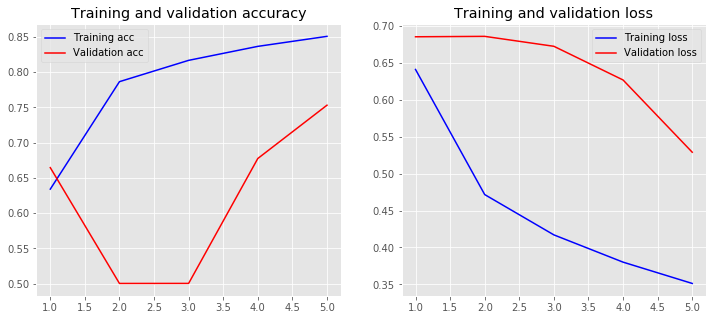

In [0]:
plot_history(history_dropout_batchnorm)